## MLOps. Практическое задание №5
### Цель задания
Применить средства автоматизации тестирования python для автоматического тестирования качества работы модели машинного обучения на различных датасетах.

Загружаем необходимые библиотеки

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Генерируем данные для датасета

In [86]:
def data_generator(sample_size: int,
                   err_val: int=None) -> pd.DataFrame:
    '''Генерируем данные для датасета'''

    feature_A = 25 * np.random.randn(sample_size) + 110
    feature_B = 35 * np.random.randn(sample_size) + 190
    feature_C = 10 * np.random.randn(sample_size) + 30

    result = 2 * feature_A \
             + 8 * feature_B \
             + feature_C \
             + 25 * np.random.randn(sample_size) + 35

    df = pd.DataFrame({
        'A': feature_A,
        'B': feature_B,
        'C': feature_C,
        'D': result})

    if err_val:
        idx = np.random.randint(0, sample_size, round(sample_size * 0.1))
        df.loc[idx, 'B'] = df.loc[idx, 'B'] * err_val

    return df

**Создаем три датасета с «качественными данными», на которых можно обучить простую модель линейной регрессии**

In [87]:
df_1 = data_generator(5500)
df_2 = data_generator(6500)
df_3 = data_generator(6500)

**Создаем датасет с шумом в данных**

In [88]:
df_err = data_generator(4000, 2)

**Сохраняем полученные датасеты**

In [89]:
df_1.to_csv('./dataset_1.csv', index=False)
df_2.to_csv('./dataset_2.csv', index=False)
df_3.to_csv('./dataset_3.csv', index=False)
df_err.to_csv('./dataset_err.csv', index=False)

**Визуализируем зависимость целевой переменой от признака "В" на одном датасете**

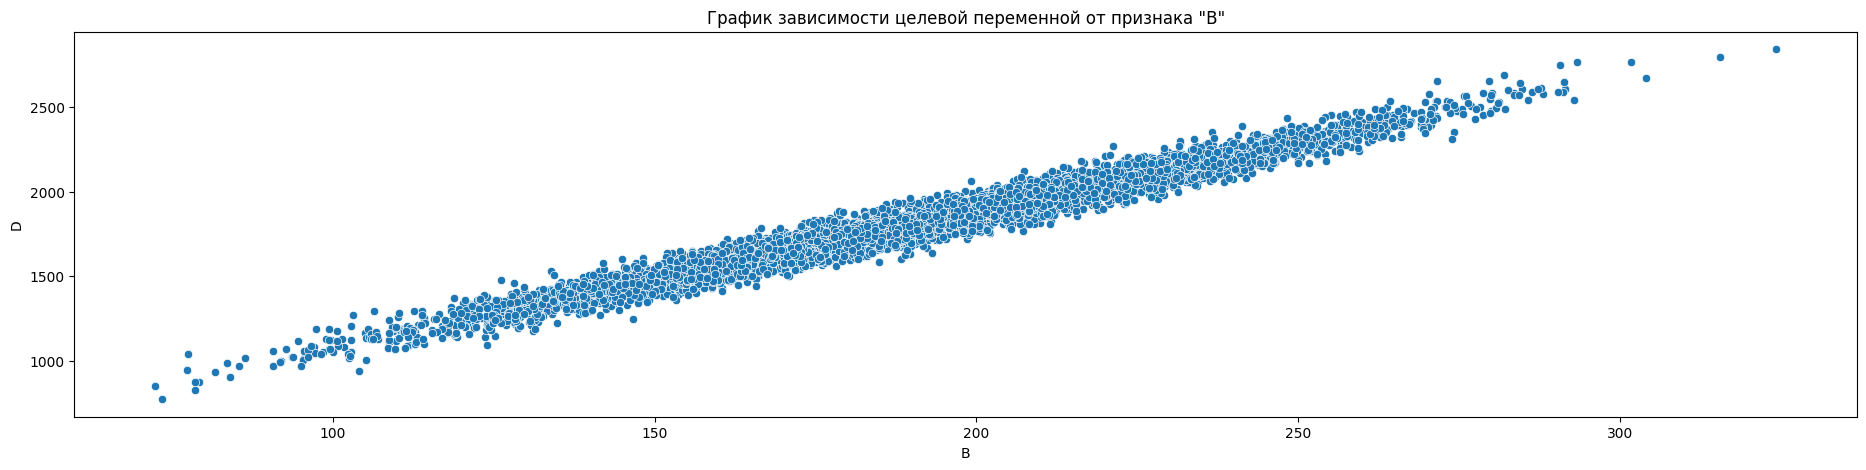

In [90]:
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_2, 
                            x='B', 
                            y='D');

scat_plot.set_title('График зависимости целевой переменной от признака "B"');

И для датасета с шумами в данных:

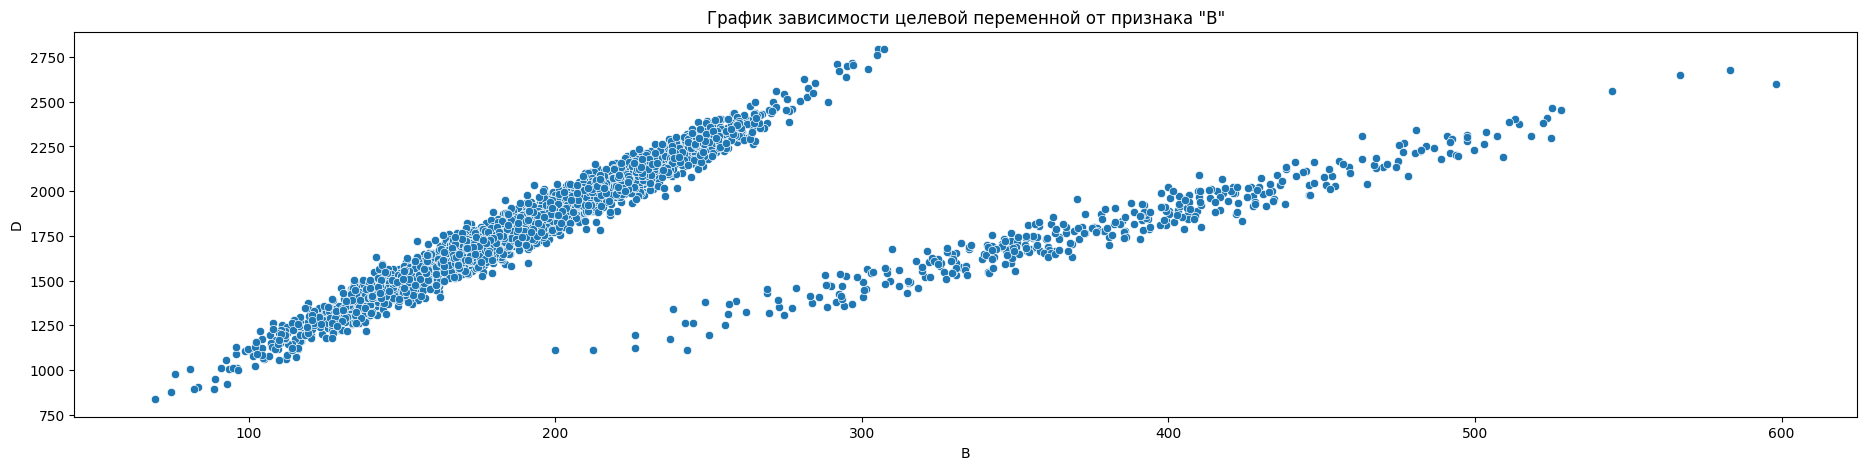

In [91]:
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_err, 
                            x='B', 
                            y='D');

scat_plot.set_title('График зависимости целевой переменной от признака "B"');

Подключаем нужную библиотеку и начинаем обучение:

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
train_y = df_2['D']
train_X = df_2.drop('D', axis=1)

model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

In [94]:
pkl_filename = 'model.pkl'
with open(pkl_filename, 'wb') as file_:
    pickle.dump(model, file_)

**Протестируем полученную модель на 1-ом и 3-м датасетах**

In [95]:
test_y = df_1['D']
test_X = df_1.drop('D', axis=1)

model.score(test_X, test_y)

0.9923857588971511

In [96]:
test_y = df_3['D']
test_X = df_3.drop('D', axis=1)

model.score(test_X, test_y)

0.9922536731743299

**Теперь протестируем на датасете с шумами:**

In [97]:
test_y = df_err['D']
test_X = df_err.drop('D', axis=1)

model.score(test_X, test_y)

-1.7883184930865443

Метрика равна 0,99 (на датасете с шумами не берем во внимание)

**Пытаемся обнаружить проблемы в датасете**

In [98]:
df_2.describe()

,A,B,C,D
count,6500.000000,6500.000000,6500.000000,6500.000000
mean,110.279100,190.452007,30.097115,1809.266007
std,25.111507,35.074790,10.102816,286.815134
min,24.218764,72.468836,-6.775101,772.787218
25%,93.205070,167.009472,23.239968,1621.357841
50%,110.392340,190.884646,29.972345,1808.251456
75%,127.380401,213.826031,37.069095,2000.372493
max,207.592780,324.166602,67.752275,2841.791774


<Axes: xlabel='B', ylabel='Count'>

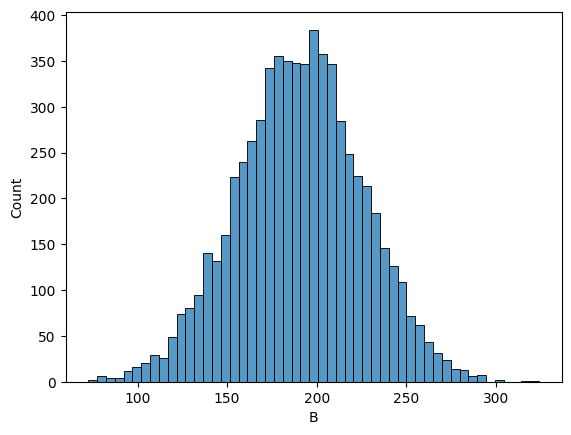

In [99]:
sns.histplot(df_2['B'])

И для датасета с шумами:

In [100]:
df_err.describe()

,A,B,C,D
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,110.484001,207.131524,29.730520,1799.354878
std,24.715567,68.473680,9.810441,285.641070
min,10.594053,69.583963,-19.317318,836.877468
25%,94.004096,168.222458,23.073025,1607.440667
50%,110.381385,193.686370,29.676242,1796.457614
75%,127.392627,222.796443,36.358796,1993.752221
max,192.363890,598.123073,65.705935,2793.720045


<Axes: xlabel='B', ylabel='Count'>

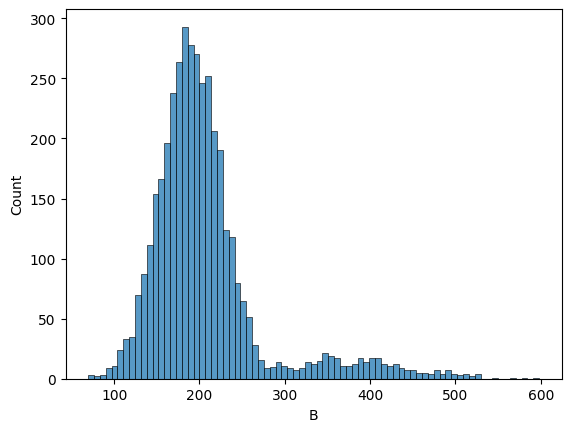

In [101]:
sns.histplot(df_err.B)

При помощи выбросов и дисперсии проблемы обнаруживаются бысрее - более наглядно. 

Отслеживая значения метрики ниже 0,99 и изменения параметра std выборки, а также max и min значений, можно определить ошибку.

In [102]:
%%writefile 'test_datasets.py' 

import pytest
import os
import pandas as pd
import pickle


datasets = {}
files = os.listdir('./')
for df_file in files:
    if df_file.endswith('.csv'):
        print(df_file)
        datasets[df_file] = pd.read_csv(os.path.join('./', df_file))

pkl_filename = 'model.pkl'
with open(pkl_filename, 'rb') as file_:
    model = pickle.load(file_)



def test_metric_crash():
    '''Протестируем метрику'''
    for dataset in datasets:
        test_y = datasets[dataset]['D']
        test_X = datasets[dataset].drop('D', axis=1)
        assert model.score(test_X, test_y) > 0.98


def test_std():
    '''Протестируем дисперсию'''
    for dataset in datasets:
        assert datasets[dataset]['B'].std() < 50


def test_median():
    '''Протестируем медиану'''
    for dataset in datasets:
        assert 150 < datasets[dataset]['B'].median() < 300

Overwriting test_datasets.py


Запускаем pytest:

In [103]:
!pytest -v

============================= test session starts =============================
platform win32 -- Python 3.9.0, pytest-8.2.2, pluggy-1.5.0 -- c:\program files\python39\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\Енотик\Desktop\Новая папка 1
plugins: anyio-4.2.0
collecting ... collected 3 items

test_datasets.py::test_metric_crash FAILED                               [ 33%]
test_datasets.py::test_std FAILED                                        [ 66%]
test_datasets.py::test_median PASSED                                     [100%]

================================== FAILURES ===================================
______________________________ test_metric_crash ______________________________

    def test_metric_crash():
        '''Протестируем метрику'''
        for dataset in datasets:
            test_y = datasets[dataset]['D']
            test_X = datasets[dataset].drop('D', axis=1)
>           assert model.score(test_X, test_y) > 0.98
E           assert -1.788318493086544 > 0

Удаляем датасет с шумами в данных:

In [104]:
import os

os.remove('./dataset_err.csv')

Повторно проверяем:

In [105]:
!pytest -v

============================= test session starts =============================
platform win32 -- Python 3.9.0, pytest-8.2.2, pluggy-1.5.0 -- c:\program files\python39\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\Енотик\Desktop\Новая папка 1
plugins: anyio-4.2.0
collecting ... collected 3 items

test_datasets.py::test_metric_crash PASSED                               [ 33%]
test_datasets.py::test_std PASSED                                        [ 66%]
test_datasets.py::test_median PASSED                                     [100%]

============================== 3 passed in 2.41s ==============================
